In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append("../../../src")

from mask_dataset import MaskedDataset
dataset_mbert = MaskedDataset(model_name='mbert')
dataset_xlmr = MaskedDataset(model_name='xlmr')

Load pre-saved file /home/xzhao/workspace/probing-mulitlingual/result/dataset-mbert/mlama-dataset.pkl for MaskedDataset instance
Load pre-saved file /home/xzhao/workspace/probing-mulitlingual/result/dataset-xlmr/mlama-dataset.pkl for MaskedDataset instance


In [2]:
from pred_evaluation import get_full_match_matrix_by_uuid, calculate_overall_p1_score_from_match_matrix, calculate_overall_p1_score_standard
xlmr_langs, xlmr_uuids, xlmr_full_matrix = get_full_match_matrix_by_uuid(dataset_xlmr, reload=False)
bert_langs, bert_uuids, bert_full_matrix = get_full_match_matrix_by_uuid(dataset_mbert)
lang2p1_xlmr = calculate_overall_p1_score_from_match_matrix(xlmr_full_matrix, xlmr_langs, dataset_xlmr)
lang2p1_bert = calculate_overall_p1_score_from_match_matrix(bert_full_matrix, bert_langs, dataset_mbert)

from pred_evaluation import calculate_objwise_score_from_match_matrix
lang2obj2p1_xlmr = calculate_objwise_score_from_match_matrix(xlmr_full_matrix, xlmr_langs, dataset_xlmr)
lang2obj2p1_mbert = calculate_objwise_score_from_match_matrix(bert_full_matrix, bert_langs, dataset_mbert)

def get_masknum2cnt_per_lang(dataset, lang2obj2p1):
    lang2masknum2cnt_p1 = {}
    for lang in lang2obj2p1:
        lang2masknum2cnt_p1[lang] = {}
        for obj_uri in lang2obj2p1[lang]:
            p1 = lang2obj2p1[lang][obj_uri][0] / lang2obj2p1[lang][obj_uri][1]
            masknum = len(dataset.obj_info[obj_uri][lang]['obj_ids'])
            lang2masknum2cnt_p1[lang].setdefault(masknum, []).append(p1)
        for masknum in lang2masknum2cnt_p1[lang]:
            lang2masknum2cnt_p1[lang][masknum] = (sum(lang2masknum2cnt_p1[lang][masknum])/len(lang2masknum2cnt_p1[lang][masknum]), len(lang2masknum2cnt_p1[lang][masknum]))
    for lang in lang2masknum2cnt_p1:
        sorted_cnt = sorted(lang2masknum2cnt_p1[lang], key=lambda k: lang2masknum2cnt_p1[lang][k], reverse=True)
        lang2masknum2cnt_p1[lang] = [(cnt, lang2masknum2cnt_p1[lang][cnt]) for cnt in sorted_cnt]
    return lang2masknum2cnt_p1

lang2masknum2cnt_mbert = get_masknum2cnt_per_lang(dataset_mbert, lang2obj2p1_mbert)
lang2masknum2cnt_xlmr = get_masknum2cnt_per_lang(dataset_xlmr, lang2obj2p1_xlmr)

In [3]:
lang2masknum2cnt_mbert["en"]

[(1, (0.15099472072789233, 2464)),
 (2, (0.12606800863664203, 397)),
 (3, (0.11452634245187439, 141)),
 (5, (0.1111111111111111, 1)),
 (4, (0.0, 24))]

In [3]:
# for lang in ['ja', 'af', 'en']:
for lang in ['ja', 'af', 'it']:
    print("Language   Model   One-token P@1   One-token objects")
    _, (p1, token_cnt) = lang2masknum2cnt_mbert[lang][0]

    print(lang, "        mbert: ", p1, token_cnt)
    _, (p1, token_cnt) = lang2masknum2cnt_xlmr[lang][0]
    print(lang, "        xlmr: ", p1, token_cnt)

Language   Model   One-token P@1   One-token objects
ja         mbert:  0.15337653197630732 126
ja         xlmr:  0.14733706479385256 244
Language   Model   One-token P@1   One-token objects
af         mbert:  0.1700598219336217 498
af         xlmr:  0.16581095175666033 333
Language   Model   One-token P@1   One-token objects
it         mbert:  0.15272188998912062 1675
it         xlmr:  0.13672725583618742 923


In [4]:
def display_cnt_p1_correlation(dataset, lang2masknum2cnt, lang2p1):
    def normalize_cnt(masknum2cnt_p1, overall_p1):
        p1_sum = sum([p1 for _, (p1, _) in masknum2cnt_p1])
        return {cnt: p1/p1_sum for cnt, (p1, _) in masknum2cnt_p1}

    cnt2normp1 = {}
    for lang in dataset.langs:
        cnt2p1 = normalize_cnt(lang2masknum2cnt[lang], lang2p1[lang])
        for cnt in cnt2p1:
            if cnt not in cnt2normp1:
                cnt2normp1[cnt] = cnt2p1[cnt]
            else:
                cnt2normp1[cnt] += cnt2p1[cnt]

    sorted_cnt = sorted([cnt for cnt in cnt2normp1 if cnt2normp1[cnt] > 0])
    sorted_p1 = [cnt2normp1[cnt] for cnt in sorted_cnt]


    correlation = np.corrcoef(sorted_cnt, sorted_p1)[0, 1]

    fig, ax1 = plt.subplots(figsize=(12, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Token numbers of predicted object')
    ax1.set_ylabel('Normalized prediction rate', color=color)
    ax1.plot(sorted_cnt, sorted_p1, color=color, marker='o')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xticks(sorted_cnt)
    ax1.set_xticklabels(sorted_cnt, rotation=90)

    text_str = f'Correlation: {correlation:.2f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # Place text on figure. x=0.05 and y=0.95 places the text at the top left corner of the figure
    ax1.text(0.05, 0.95, text_str, transform=ax1.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

    plt.title('Correlation between token number and prediction rate')
    plt.grid(True)
    plt.show()

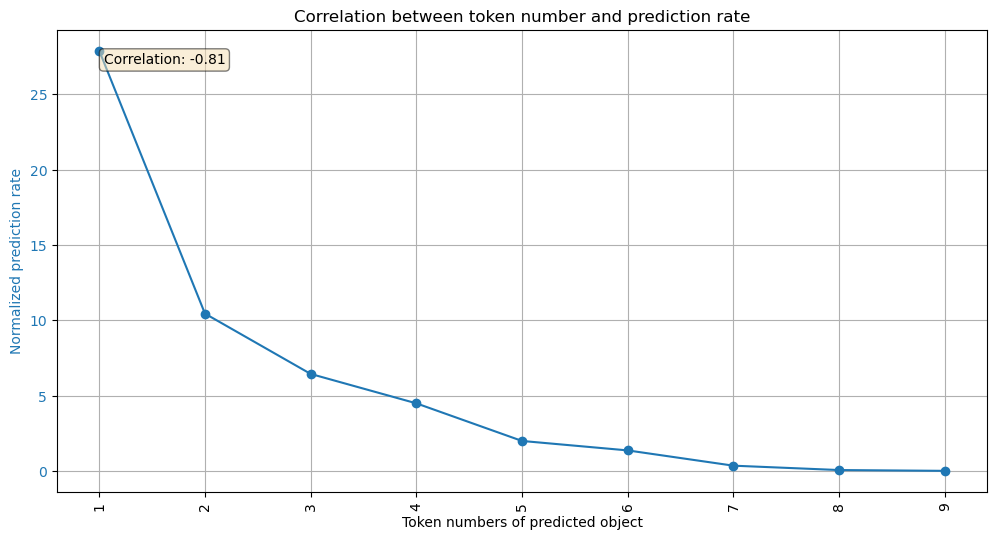

In [5]:
display_cnt_p1_correlation(dataset_mbert, lang2masknum2cnt_mbert, lang2p1_bert)

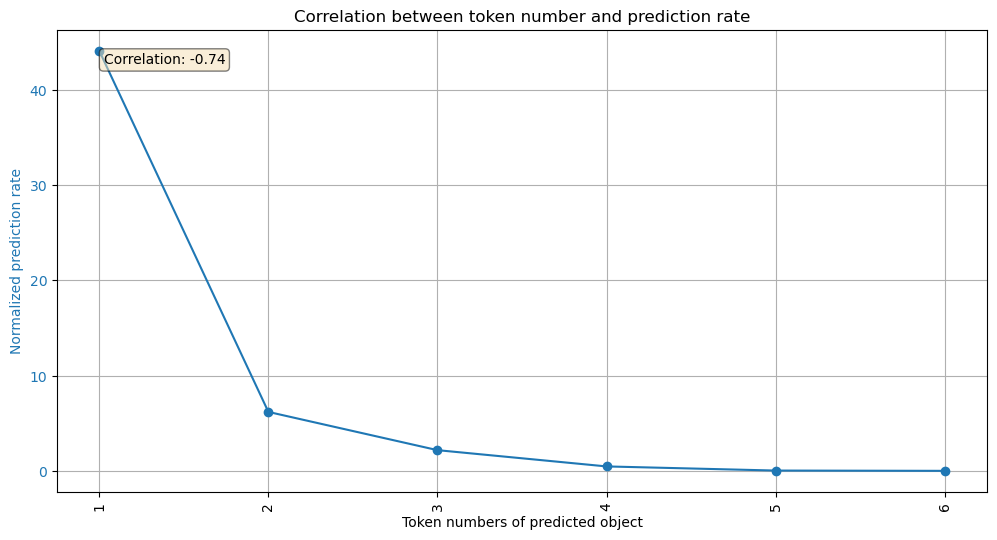

In [6]:
display_cnt_p1_correlation(dataset_xlmr, lang2masknum2cnt_xlmr, lang2p1_xlmr)

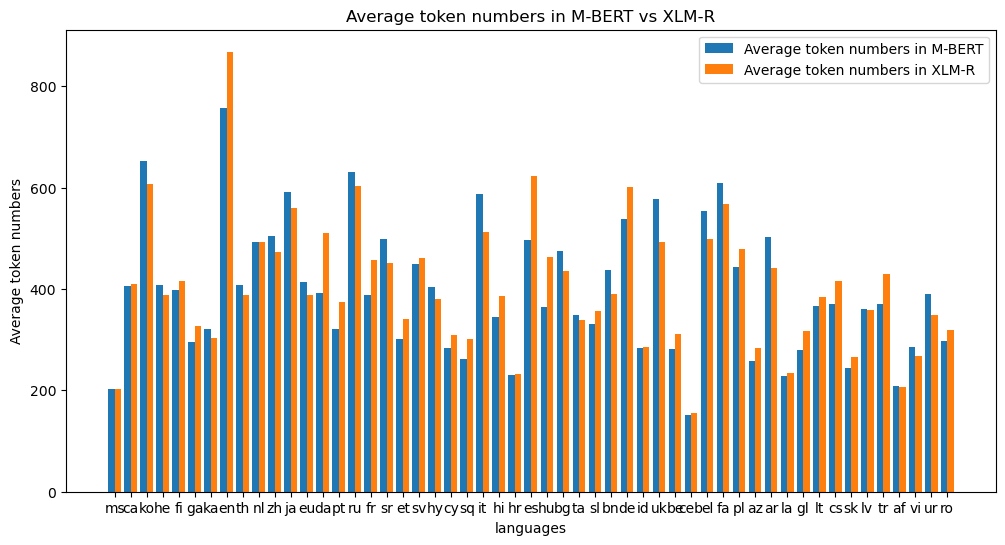

In [7]:

def display_average_token_number(masknum2cnt):
    total = 0
    total_num = 0
    for token_num, (_, cnt) in masknum2cnt:
        total

langs = []
mbert_length = []
xlmr_length = []
for lang in dataset_mbert.langs:
    langs.append(lang)
    mbert_len = 0
    xlmr_len = 0
    for length, (p1, count) in lang2masknum2cnt_mbert[lang]:
        mbert_len += length * count
    for length, (p1, count) in lang2masknum2cnt_xlmr[lang]:
        xlmr_len += length * count
    mbert_len /= len(lang2masknum2cnt_mbert[lang])
    xlmr_len /= len(lang2masknum2cnt_xlmr[lang])
    mbert_length.append(mbert_len)
    xlmr_length.append(xlmr_len)

# Setting the positions and width for the bars
bar_width = 0.8
index = np.arange(0, len(langs) * 2, 2)

# Creating the bars
fig, ax = plt.subplots(figsize=(12, 6))
bar1 = ax.bar(index, mbert_length, bar_width, label='Average token numbers in M-BERT')
bar2 = ax.bar(index + bar_width, xlmr_length, bar_width, label='Average token numbers in XLM-R')

# Labeling, title and axes ticks
ax.set_xlabel('languages')
ax.set_ylabel('Average token numbers')
ax.set_title('Average token numbers in M-BERT vs XLM-R')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(langs)
ax.legend()

# Displaying the figure
# plt.tight_layout()
plt.show()